## Dog Breed Prediction

In [1]:
# Set Parameters

# Batch Size for all Datasets
BATCH_SIZE = 256

# Maximum number of Epochs for Training
EPOCHS = 10


In [2]:
import math
import pandas as pd
import tensorflow as tf
import keras.layers as layers
from keras.models import Model
import matplotlib.pyplot as plt

from matplotlib.image import imread
from callbacks import TrainCallback
from keras.applications import xception
from IPython.display import clear_output
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


#### Get Dataset form Kaggle

In [3]:
# Download Dataset
!mkdir dataset
%cd dataset
!kaggle datasets download catherinehorng/dogbreedidfromcomp
clear_output()


In [4]:
# Unzip Dataset
!tar -xf dogbreedidfromcomp.zip


In [5]:
# Delete Unwanted Files
!del dogbreedidfromcomp.zip
!del sample_submission.csv
!rmdir /s/q test  # No label data available
%cd ..
clear_output()


#### Loading FilePaths in Pandas DataFrame

In [6]:
data_df = pd.read_csv('dataset/labels.csv')
data_df['id'] = data_df['id'].apply(lambda x: f'dataset/train/{x}.jpg')


#### Vizualizing Some Data

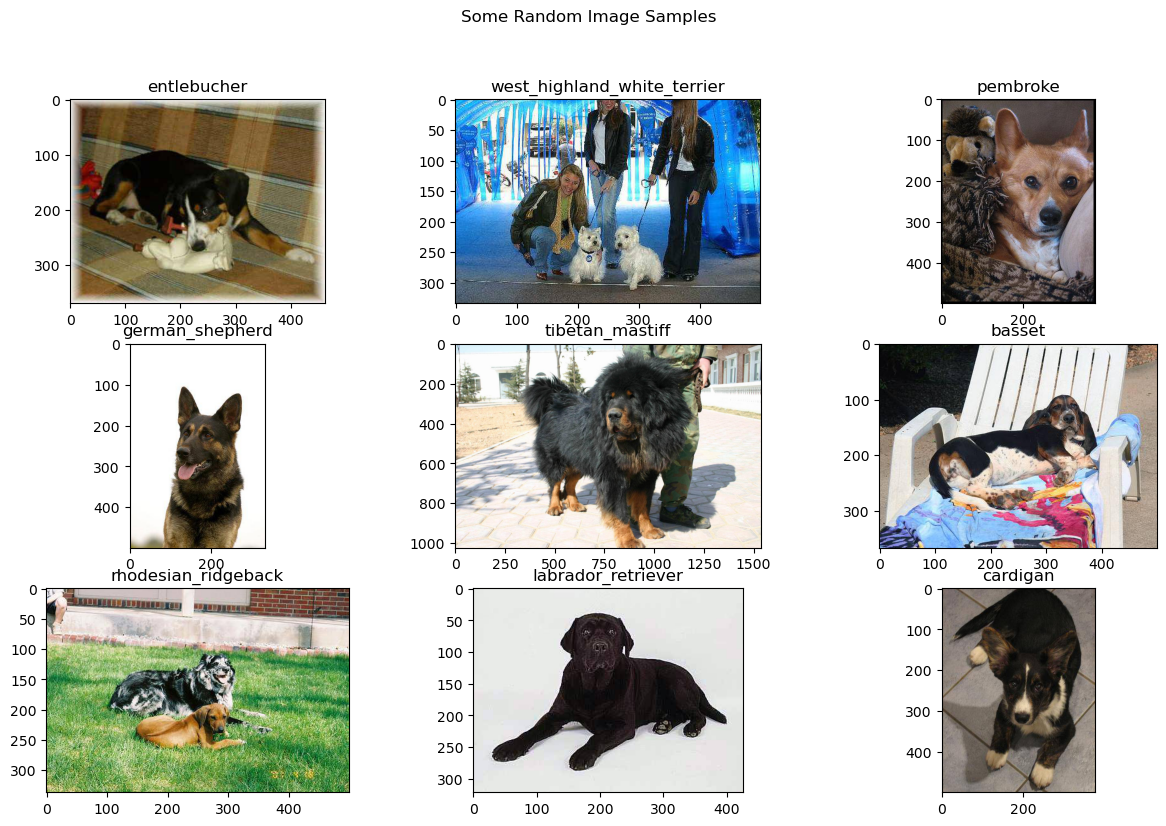

In [7]:
# Vizualize some random images
images = data_df.sample(n=9)
fig, ax = plt.subplots(3, 3, figsize=(15, 9))
fig.suptitle('Some Random Image Samples')
for i in range(3):
    for j in range(3):
        k = 3 * i + j
        img = imread(images.iloc[k, 0])
        ax[i][j].imshow(img)
        ax[i][j].set_title(images.iloc[k, 1])


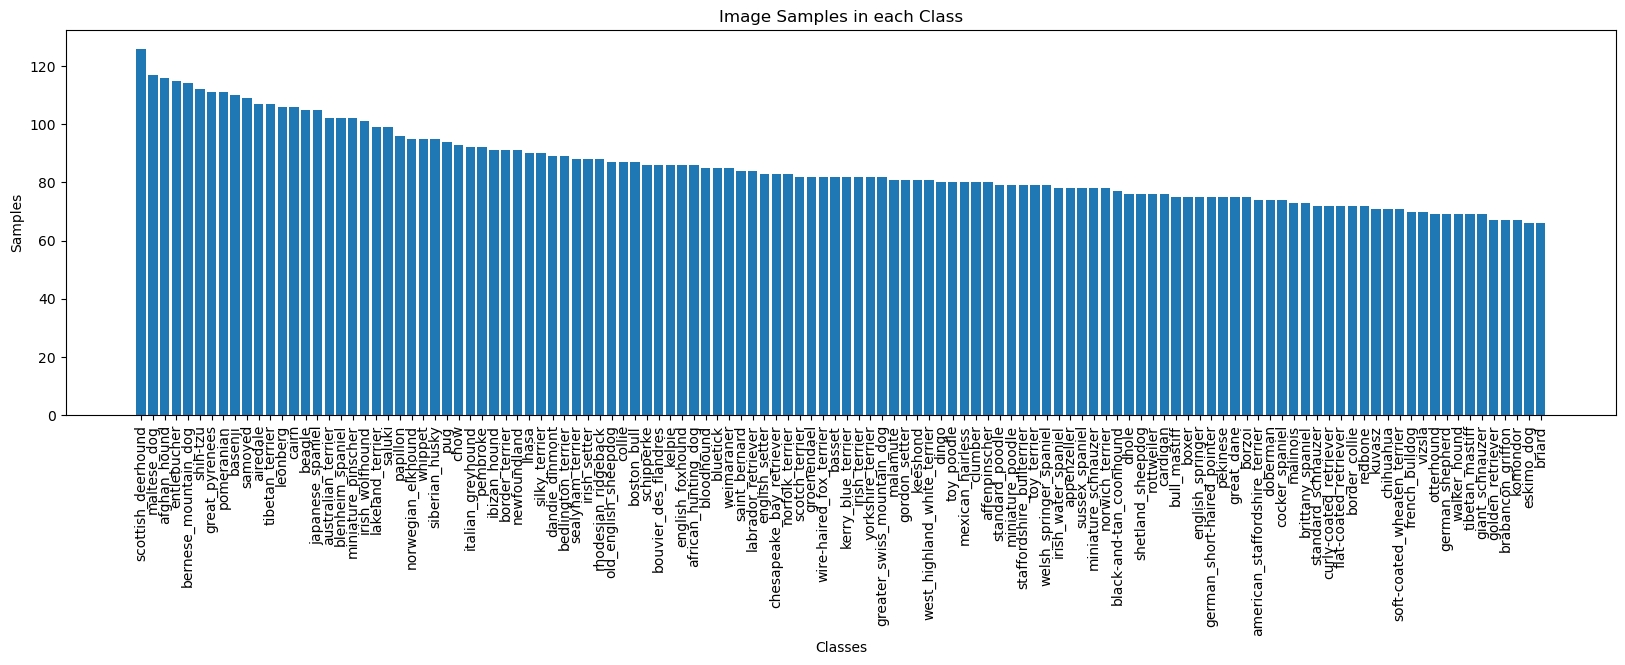

In [8]:
# Vizualize count of each breed
data = data_df['breed'].value_counts()

fig, ax = plt.subplots(figsize=(20, 5))
ax.set_xlabel('Classes')
ax.set_ylabel('Samples')
ax.set_title('Image Samples in each Class')
ax.bar(data.index, data)
ax.tick_params(axis='x', labelrotation=90)


#### Setting Up Data

In [9]:
# Label Encoding
encoder = LabelEncoder().fit(data_df['breed'].unique())
data_df['breed'] = encoder.transform(data_df['breed'])


In [10]:
# Splitting the data set into training and testing data sets
train_df, test_df = train_test_split(data_df, test_size=0.1)

# Splitting the training data set into training and validation data sets
train_df, val_df = train_test_split(train_df, test_size=0.2)


In [11]:
scaling_layer = layers.Rescaling(1.0/127.5, offset=-1)


def load_dataframe(df, preprocessing_layers):
    ds = tf.data.Dataset.from_tensor_slices((df['id'], df['breed']))
    ds = ds.map(lambda x, y: (tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(x), channels=3), size=(299, 299)), y), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    ds = ds.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

    for layer in preprocessing_layers:
        ds = ds.map(lambda x, y: (layer(x), y), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

    # Optimize Performance
    ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    return ds


train_ds = load_dataframe(train_df, [scaling_layer])
val_ds = load_dataframe(val_df, [scaling_layer])
test_ds = load_dataframe(test_df, [scaling_layer])


#### Modelling

In [12]:
# Building the Model
base_model = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
base_model.trainable = False

input = tf.keras.Input(shape=(299, 299, 3), name='Input_Layer')
output = base_model(input)
output = layers.Dense(120, activation='softmax')(output)

model = Model(inputs=input, outputs=output)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [13]:
# Training the model
batches = math.ceil(len(train_df)/BATCH_SIZE)

callback = TrainCallback(model, batches, EPOCHS, epoch_patience=2, lr_patience=2)
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=2, callbacks=[callback])


Epoch 1/10
29/29 - 46s - loss: 3.1805 - accuracy: 0.6048 - val_loss: 1.6863 - val_accuracy: 0.8538 - 46s/epoch - 2s/step
Epoch 2/10
29/29 - 39s - loss: 1.0100 - accuracy: 0.8943 - val_loss: 0.6717 - val_accuracy: 0.8918 - 39s/epoch - 1s/step
Epoch 3/10
29/29 - 39s - loss: 0.5021 - accuracy: 0.9174 - val_loss: 0.4779 - val_accuracy: 0.9011 - 39s/epoch - 1s/step
Epoch 4/10
29/29 - 39s - loss: 0.3750 - accuracy: 0.9265 - val_loss: 0.4104 - val_accuracy: 0.9033 - 39s/epoch - 1s/step
Epoch 5/10
29/29 - 39s - loss: 0.3142 - accuracy: 0.9318 - val_loss: 0.3755 - val_accuracy: 0.9022 - 39s/epoch - 1s/step
Epoch 6/10
29/29 - 39s - loss: 0.4035 - accuracy: 0.9258 - val_loss: 0.4692 - val_accuracy: 0.9016 - 39s/epoch - 1s/step
Epoch 7/10
29/29 - 39s - loss: 0.3927 - accuracy: 0.9269 - val_loss: 0.4596 - val_accuracy: 0.9027 - 39s/epoch - 1s/step


#### Model Evaluation

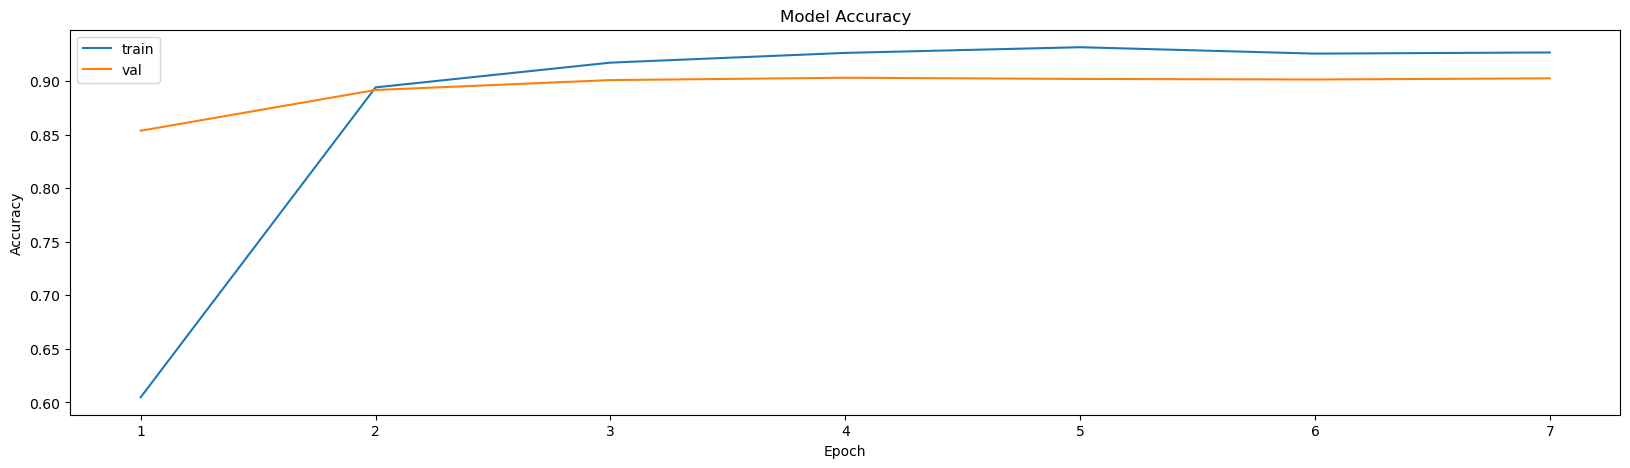

In [14]:
# Plot the training history
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label='train')
ax.plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label='val')
_ = ax.legend()


In [15]:
# Model Accuracy on Test Data
score = model.evaluate(test_ds)
print(f'Accuracy over the test set: {round((score[1]*100), 2)}%')


4/4 [==============================] - 6s 1s/step - loss: 0.4723 - accuracy: 0.8944
Accuracy over the test set: 89.44%


In [16]:
model.save('model.h5')
